In [170]:
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss

In [76]:
distances = '/nobackup_1/users/straaten/match/test_distances2.hdf'
ids = '/nobackup_1/users/straaten/match/test_ids2.hdf'
distances = pd.read_hdf(distances)
ids = pd.read_hdf(ids)

In [83]:
code_table = pd.Series(['None','AR','SNAO-','NAlow','block'], pd.Index(range(-1,4), name = 'clustid'), name = 'alias')

### Distance to clusters
Should not be a linear function of time (regimes are on detrended data), can have variability in time of course: 

*However, the relative frequency of each jet regime exhibits a pronounced multiyear/decadal variability over the twentieth century. This might be further evidence for the suggested paradigm that the time-mean response of a system
to some imposed (internal or external) forcing manifests itself through a change in regime frequencies (Palmer, 1999; Corti et al. 1999)*

We also expect it to be a function of leadtime. Initialization -> drift towards model space that stops resembling (all or some of) the observed regimes.

In [77]:
dist_ftime = distances.loc[:,['time','clustid','observation']].drop_duplicates().set_index(['time','clustid']).unstack('clustid')

<AxesSubplot:xlabel='time'>

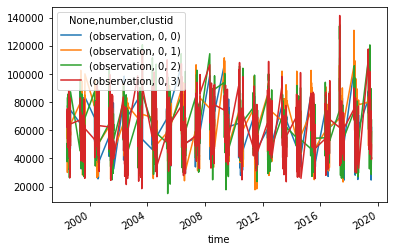

In [78]:
dist_ftime.plot()

array([[<AxesSubplot:title={'center':"('observation', 0, 0)"}>,
        <AxesSubplot:title={'center':"('observation', 0, 1)"}>],
       [<AxesSubplot:title={'center':"('observation', 0, 2)"}>,
        <AxesSubplot:title={'center':"('observation', 0, 3)"}>]],
      dtype=object)

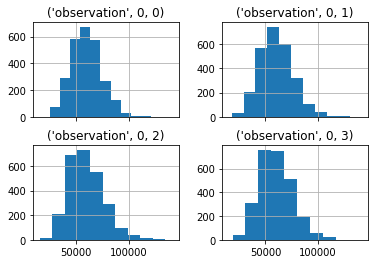

In [79]:
dist_ftime.hist(sharex = True)

Observed distances have the mean around 60000. Forecast distances a tiny bit higher. It used to be a lot lower, which had to do with faulty projection. And perhaps a very tiny part of the difference is that the forecast field is more 'smeared out' in comparison with the from highres resampled observations

In [80]:
distances.groupby('clustid').apply(lambda df: df.mean(axis = 0))

/tmp/ipykernel_414611/2808063067.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  distances.groupby('clustid').apply(lambda df: df.mean(axis = 0))


clustid   leadtime      forecast                              \
number                                 0             1             2   
clustid                                                                
0           0.0  23.738316  60090.454643  61075.262805  60667.619833   
1           1.0  23.738316  62872.726538  63649.475811  63452.625786   
2           2.0  23.738316  59346.685322  59782.400715  59454.826119   
3           3.0  23.738316  60225.458194  60901.153337  60802.756272   

                                                                               \
number              3             4             5             6             7   
clustid                                                                         
0        60638.363387  60993.929034  61022.561578  61002.124991  60655.369666   
1        63477.259630  63742.955907  63599.894842  63596.783015  63630.009635   
2        59652.850391  59531.481936  59558.618917  59531.691011  59303.077714   
3        60631.191575  60787.819972  60637.651542  60857.133695  60560.247045   

                                                    observation  
number              8             9            10             0  
clustid                                                          
0        60727.454152  60477.479486  60801.188425  59573.391080  
1        63573.436456  63342.330724  63795.120445  60584.555403  
2        59629.537330  59341.701409  59472.783257  59326.786487  
3        60377.932712  60872.925211  60639.690142  59902.564758

In [81]:
dist_fleadtime = distances.loc[:,['clustid','time','leadtime','forecast']].set_index(['clustid','leadtime'])
dist_fleadtime['ensmean'] = dist_fleadtime['forecast'].mean(axis = 1)

<AxesSubplot:xlabel='leadtime'>

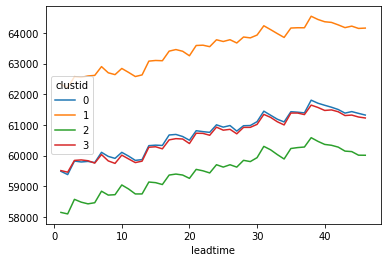

In [82]:
dist_fleadtime['ensmean'].groupby(['clustid','leadtime']).mean().unstack('clustid').plot()

This looks like a pretty stable stratification. The order of 1 having the largest distances and 2 the lowest might well correspond to observations.

### Assigned clusters
Assigned to minimum distance, given the fact that this minimum is below the allowed maximum of 60000.

We expect a preferential assignment with leadtime. Certainly that we have more NO regimes (as distances increase with leadtime).

In [85]:
np.unique(ids['observation'], return_counts = True)

(array([-1.,  0.,  1.,  2.,  3.]), array([3923, 6535, 7372, 9337, 7646]))

In [86]:
np.unique(ids[('forecast',0)], return_counts = True) # The control is sligthly different. More preference for 3 = blocks?

(array([-1,  0,  1,  2,  3]), array([4512, 6581, 6190, 9314, 8216]))

In [87]:
np.unique(ids[('forecast',1)], return_counts = True)

(array([-1,  0,  1,  2,  3]), array([4916, 6166, 6067, 9575, 8089]))

In [98]:
np.unique(ids[('forecast',4)], return_counts = True)

(array([-1,  0,  1,  2,  3]), array([4841, 6318, 5973, 9644, 8037]))

In [90]:
forecast_freqs = ids.groupby('leadtime').apply(lambda df: pd.Series(np.unique(df['forecast'], return_counts = True)[-1] / df['forecast'].size, index = pd.Index(range(-1,4), name = 'clustid')))
obs_freqs = pd.Series(np.unique(ids['observation'], return_counts = True)[-1] / len(ids), index = pd.Index(range(-1,4), name = 'clustid'))

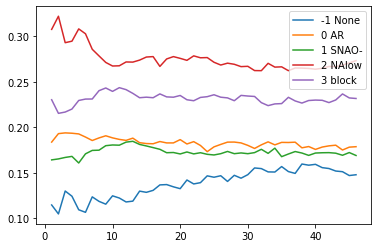

In [94]:
fig, ax = plt.subplots()
for clustid in obs_freqs.index:
    ax.plot(forecast_freqs.index, forecast_freqs.loc[:,clustid], label = f'{clustid} {code_table.loc[clustid]}')
ax.legend()

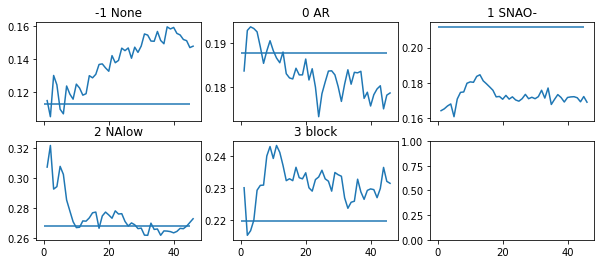

In [96]:
# Better look at the trends
fig, axes = plt.subplots(nrows = 2, ncols=3, squeeze = False, sharex = True, figsize = (10,4))
for i, clustid in enumerate(obs_freqs.index):
    ax = axes[i//3,i%3]
    im = ax.plot(forecast_freqs.index, forecast_freqs.loc[:,clustid], label = clustid)
    ax.set_title(f'{clustid} {code_table.loc[clustid]}')
    ax.hlines(y = obs_freqs.loc[clustid], xmin = 0, xmax = 45)

Overall these frequencies are pretty close (i.e. climatologically reliable). Of course it could still be that conditionally that are more off. Can we verify these?

In [123]:
scores = pd.Series(np.nan, index = pd.MultiIndex.from_product([ids.leadtime.unique(),code_table.index], names = ['leadtime','clustid']))
for leadtime, clustid in scores.index:
    subset = ids.loc[(ids['leadtime'] == leadtime).values,:]
    pi = ((subset['forecast'] == clustid).sum(axis = 1))/11 # + 0.5) / 12
    oi = (subset['observation'] == clustid)
    scores.loc[(leadtime,clustid)] = brier_score_loss(y_true = oi, y_prob=pi)
scores = scores.unstack('clustid')

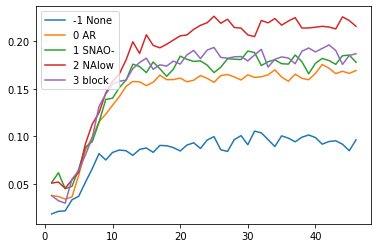

In [124]:
fig, ax = plt.subplots()
for clustid in scores.columns:
    ax.plot(scores.index, scores.loc[:,clustid], label = f'{clustid} {code_table.loc[clustid]}')
ax.legend()

This verification happens on a day by day basis. We expect a bit more scale when less sensitive to timing. We also expect for instance that the timeseries will be of higher use when the period matches the predictand period.

### Aggregating the predictions.
In a window we have no single observation anymore, but also a distribution of regimes over time. We can collapse the problem into the divergence between two (5 category) histograms, disregarding timing.

When counting the occurrences in forecasts this means that a few days with 100% chance is equivalent to each day a small chance.

Requires a 2D rolling in time and leadtime. Basically: for all timesteps we want to find the (multiple) leadtimes forecasting that timestep, join for each of those the subsequent leadtimes.

In [427]:
timespread = ids[['forecast','time','leadtime']].set_index(['time','leadtime']).stack('number')
forecast_arr = timespread['forecast'].to_xarray()
obs = ids[[('observation',0),('time','')]].drop_duplicates().set_index('time').iloc[:,0]
obs_arr = ids[['observation','time','leadtime']].set_index(['time','leadtime']).iloc[:,0].to_xarray()
forecast_arr = obs_arr

In [421]:
firstdays = timespread.loc[(slice(None),1,0),:].index.get_level_values('time')

In [394]:
firstdays

DatetimeIndex(['1998-06-07', '1998-06-11', '1998-06-14', '1998-06-18',
               '1998-06-21', '1998-06-25', '1998-06-28', '1998-07-02',
               '1998-07-05', '1998-07-09',
               ...
               '2019-05-09', '2019-05-13', '2019-05-16', '2019-05-20',
               '2019-05-23', '2019-05-27', '2019-05-30', '2019-06-03',
               '2019-06-06', '2019-06-10'],
              dtype='datetime64[ns]', name='time', length=694, freq=None)

In [428]:
timeagg = 12 # days
clustids = pd.Index(range(-1,4), name = 'clustid')
total_window_occurrences = pd.DataFrame(np.nan, index = ids.set_index(['time','leadtime']).index, columns = clustids) # Pre-allocation , clustid, time, leadtime
#total_observed_occurrences = pd.DataFrame(np.nan, index = total_window_occurrences.index, columns = clustids) # Same dataframe but only varying over time, not leadtime
for firstday in firstdays[20:21]:
    timeslice = slice(firstday, firstday + pd.Timedelta('45D'), None) # Might point into autumn, where some leadtimes are not available
    forecasts = forecast_arr.loc[timeslice] # Therefore slicing and check availability with shape:
    print(f'run starting {firstday} has len {forecasts.shape[0]} in MJJA')
    leadtime_index_slice = xr.DataArray(np.arange(forecasts.shape[0]), dims = ('leadtime',)) # Coordinates for vectorized indexing of the available data.
    start_to_end = forecasts[leadtime_index_slice, leadtime_index_slice,...] # Vectorized (non-orthogonal indexing)
    #observed = obs.array
    temp = [] # We'll be creating a new clustid axis
    for clustid in total_window_occurrences.columns:
        if 'number' in start_to_end.dims: # Dealing with forecasts
            count = (start_to_end == clustid).sum('number') # counting over the members
        else: # Dealing with observations
            count = start_to_end == clustid
        # Now the temporal aggregation by counting over the time window.
        total_window_occurrence = count.rolling({'leadtime':timeagg}).sum() # leadtime indexed only
        temp.append(total_window_occurrence)
    comb = xr.concat(temp, dim = 'clustid')
    # Left stamping
    array = comb.assign_coords({'time':comb.time - pd.Timedelta(str(timeagg - 1) + 'D')})
    array = array.assign_coords({'leadtime':array.leadtime - (timeagg - 1)})
    array = array.isel(leadtime = slice(timeagg - 1, None))
    total_window_occurrences.loc[list(zip(array.time.values, array.leadtime.values)),:] = array.values.T # Setting values
total_window_occurrences = total_window_occurrences.dropna(axis = 0, how = 'all')

run starting 1998-08-20 00:00:00 has len 12 in MJJA


In [426]:
forc = array

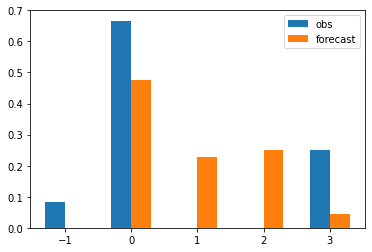

In [441]:
fig, ax = plt.subplots()
width = 0.3
x = np.arange(-1,4)
rects1 = ax.bar(x - width/2, (array / array.sum()).squeeze(), width, label='obs')
rects2 = ax.bar(x + width/2, (forc / forc.sum()).squeeze(), width, label='forecast')
plt.legend()
plt.show()